In [ ]:
import os
import time
import math
import collections
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import MultivariateNormal

In [ ]:
Batch_Description = collections.namedtuple(
    "Batch_Description",
    ("y_values", "x_values",
     "target_y", "target_x",
     "context_y", "context_x")
    )


class CurveSampler(object):
    def __init__(self, kernel):
        self._kernel = kernel

    def sample(self,
            batch_size=16,
            num_context=None,
            max_num_context=None,
            num_points=None,
            max_num_points=50,
            s_range=(-2, 2),
            device='cpu'):

        # if max_num_context is not None:
        #     assert max_num_points >= max_num_context, \
        #        f"number of context cannnot be greater than maximum number of data points"

        max_num_context = max_num_context or max_num_points
        num_points = num_points or torch.randint(low=6, high=max_num_points+1, size=[1]).item()
        num_context = num_context or torch.randint(low=3, high=min(num_points, max_num_context)-2, size=[1]).item()

        s = s_range[0] + (s_range[1] - s_range[0]) \
            * torch.rand([batch_size, num_points, 1], device=device)

        # batch_size * num_points * num_points
        x_values, y_values = self._kernel(s)

        context_x = x_values[:,:num_context]
        target_x = x_values[:,num_context:]
        context_y = y_values[:,:num_context]
        target_y = y_values[:,num_context:]

        return Batch_Description(
            x_values=x_values, y_values=y_values,
            target_x=target_x, target_y=target_y,
            context_x=context_x, context_y=context_y)


class RBFKernel(object):
    def __init__(self, sigma_eps=2e-2, length=0.25, scale=0.75):
        self._sigma_eps = sigma_eps
        self._length = length
        self._scale = scale

    # s: batch_size * num_points * dim
    def __call__(self, s):
        # batch_size * num_points * num_points * dim
        dist = (s.unsqueeze(-2) - s.unsqueeze(-3))/self._length

        # batch_size * num_points * num_points
        cov = (self._scale**2) * torch.exp(-0.5 * dist.pow(2).sum(-1)) \
              + self._sigma_eps**2 * torch.eye(s.shape[-2]).to(s.device)
        mean = torch.zeros(s.shape[0], s.shape[1], device=s.device)

        x_values = s
        y_values = MultivariateNormal(mean, cov).rsample().unsqueeze(-1)

        return x_values, y_values


class Matern52Kernel(object):
    def __init__(self, sigma_eps=2e-2, length=0.25, scale=0.75):
        self._sigma_eps = sigma_eps
        self._length = length
        self._scale = scale

    # s: batch_size * num_points * dim
    def __call__(self, s):
        # batch_size * num_points * num_points
        dist = torch.norm((s.unsqueeze(-2) - s.unsqueeze(-3))/self._length, dim=-1)

        cov = (self._scale**2) * (1 + math.sqrt(5.0)*dist + 5.0*dist.pow(2)/3.0) \
              * torch.exp(-math.sqrt(5.0) * dist) \
              + self._sigma_eps**2 * torch.eye(s.shape[-2]).to(s.device)
        mean = torch.zeros(s.shape[0], s.shape[1], device=s.device)

        x_values = s
        y_values = MultivariateNormal(mean, cov).rsample().unsqueeze(-1)

        return x_values, y_values


class DoubleSineKernel(object):
    def __init__(self, amp_range=(0.5, 1.5), freq_range=(1, 3)):
        self._amp_range = amp_range
        self._freq_range = freq_range

    # s: batch_size * num_points * dim
    def __call__(self, s):
        amp = self._amp_range[0] + (self._amp_range[1] - self._amp_range[0]) \
              * torch.rand([2, s.shape[0], 1, 1], device=s.device)
        freq = self._freq_range[0] + (self._freq_range[1] - self._freq_range[0]) \
               * torch.rand([2, s.shape[0], 1, 1], device=s.device)
        
        amp = torch.tile(amp, dims=[1, 1, s.shape[1], 1])
        freq = torch.tile(freq, dims=[1, 1, s.shape[1], 1])

        y_1 = amp[0] * torch.sin(freq[0] * s)
        y_2 = amp[1] * torch.cos(freq[1] * s)
        p_assignment = torch.rand(size=s.shape, device=s.device)

        x_values = s
        y_values = torch.where(p_assignment < 0.5, y_1, y_2)

        return x_values, y_values


class CircularKernel(object):
    def __init__(self, radius_range=(0.5, 1.5), shift_range=(-0.5, 0.5)):
        self._radius_range = radius_range
        self._shift_range = shift_range

    # s: batch_size * num_points * dim
    def __call__(self, s):
        radius = self._radius_range[0] + (self._radius_range[1] - self._radius_range[0]) \
                 * torch.rand([s.shape[0], 1, 1], device=s.device)
        shift = self._shift_range[0] + (self._shift_range[1] - self._shift_range[0]) \
                 * torch.rand([s.shape[0], 1, 1], device=s.device)
        
        radius = torch.tile(radius, dims=[1, s.shape[1], 1])
        shift = torch.tile(shift, dims=[1, s.shape[1], 1])

        x_values = radius * torch.cos(s) + shift
        y_values = radius * torch.sin(s) + shift

        return x_values, y_values


class LissajousKernel(object):
    def __init__(self, x_amp_range=(1, 2), y_amp_range=(1, 2),
                 freq_range=(0.5, 2), shift_range=(0, 2)):
        self._x_amp_range = x_amp_range
        self._y_amp_range = y_amp_range
        self._freq_range = freq_range
        self._shift_range = shift_range

    # s: batch_size * num_points * dim
    def __call__(self, s):
        x_amp = self._x_amp_range[0] + (self._x_amp_range[1] - self._x_amp_range[0]) \
                * torch.rand([s.shape[0], 1, 1], device=s.device)
        y_amp = self._y_amp_range[0] + (self._y_amp_range[1] - self._y_amp_range[0]) \
                * torch.rand([s.shape[0], 1, 1], device=s.device)
        freq = self._freq_range[0] + (self._freq_range[1] - self._freq_range[0]) \
               * torch.rand([s.shape[0], 1, 1], device=s.device)
        shift = self._shift_range[0] + (self._shift_range[1] - self._shift_range[0]) \
                * torch.rand([s.shape[0], 1, 1], device=s.device)
        
        x_amp = torch.tile(x_amp, dims=[1, s.shape[1], 1])
        y_amp = torch.tile(y_amp, dims=[1, s.shape[1], 1])
        freq = torch.tile(freq, dims=[1, s.shape[1], 1])
        shift = torch.tile(shift, dims=[1, s.shape[1], 1])

        x_values = x_amp * torch.sin(freq * s + shift)
        y_values = y_amp * torch.sin(s)

        return x_values, y_values


class SawtoothKernel(object):
    def __init__(self, amp_range=(1, 2), freq_range=(1, 3),
                 shift_range=(-2, 2), trunc_range=(10, 20)):
        self._amp_range = amp_range
        self._freq_range = freq_range
        self._shift_range = shift_range
        self._trunc_range = trunc_range

    # s: batch_size * num_points * dim
    def __call__(self, s):
        amp = self._amp_range[0] + (self._amp_range[1] - self._amp_range[0]) \
              * torch.rand([s.shape[0]], device=s.device)
        freq = self._freq_range[0] + (self._freq_range[1] - self._freq_range[0]) \
               * torch.rand([s.shape[0]], device=s.device)
        shift = self._shift_range[0] + (self._shift_range[1] - self._shift_range[0]) \
                * torch.rand([s.shape[0]], device=s.device)
        trunc = torch.randint(low=self._trunc_range[0], high=self._trunc_range[1]+1, size=[s.shape[0]],device=s.device)

        y_values = []
        for i in range(s.shape[0]):
            x = torch.tile(s[i, :, :, None], dims=[1, 1, trunc[i]]) + shift[i]
            k = torch.tile(torch.reshape(torch.arange(start=1, end=trunc[i] + 1, device=s.device), shape=(1, 1, -1)),
                           dims=[s.shape[1], 1, 1])
            y = amp[i]/2 - amp[i] / math.pi * torch.sum((-1)**k * torch.sin(2 * math.pi * k * freq[i] * x) / k, dim=-1)
            y -= 0.5 * amp[i]
            y_values.append(y)
        
        x_values = s
        y_values = torch.stack(y_values)

        return x_values, y_values


def to_cuda(batch):
    return Batch_Description(
            x_values=batch.x_values.to('cuda'),
            y_values=batch.y_values.to('cuda'),
            target_x=batch.target_x.to('cuda'),
            target_y=batch.target_y.to('cuda'),
            context_x=batch.context_x.to('cuda'),
            context_y=batch.context_y.to('cuda'))

In [ ]:
class AsymmetricLaplacian(object):
    def __init__(self, loc, scale, tau):
        self._loc = loc
        self._scale = scale
        self._tau = tau

    @property
    def mean(self):
        return self._loc + (1 - 2 * self._tau) \
               / (self._tau * (1 - self._tau)) * self._scale

    @property
    def variance(self):
      return (1 - 2 * self._tau + 2 * torch.square(self._tau)) \
             / (self._tau * (1 - self._tau)) * torch.square(self._scale)

    @property
    def stddev(self):
        return torch.sqrt(self.variance)

    def log_prob(self, y):
        log_p = torch.log(self._tau) + torch.log(1 - self._tau) \
                - torch.log(self._scale) \
                - (y - self._loc) * (self._tau - (y < self._loc).float()) / self._scale
        return log_p


class UMAL(object):
    def __init__(self, loc, scale, tau,
                 mixture_weights=None):
        if mixture_weights is None:
            mixture_weights = torch.ones_like(loc)
        self._mixture_weights = nn.functional.softmax(mixture_weights, dim=1)
        self._ALD = AsymmetricLaplacian(loc, scale, tau)
        
    @property
    def component_mean(self):
        return self._ALD.mean

    @property
    def component_stddev(self):
        return self._ALD.stddev

    @property
    def component_weight(self):
        return self._mixture_weights

    @property
    def mean(self):
        return torch.sum(torch.mul(self._ALD.mean,
                                   self._mixture_weights),
                         dim=1)

    def log_prob(self, y):
        num_tau = self._ALD._tau.shape[1]
        y = torch.tile(torch.unsqueeze(y, dim=1),
                       dims=[1, num_tau, 1, 1])
        log_p = torch.logsumexp(torch.log(self._mixture_weights+1e-10) + 
                                self._ALD.log_prob(y), dim=1)
        return log_p


class MLP(nn.Module):
    def __init__(self,
                 dimensions):
        super(MLP, self).__init__()
        self._dimensions = dimensions
        modules = []
        for i in range(len(dimensions) - 2):
            modules.append(nn.Linear(dimensions[i], dimensions[i + 1]))
            modules.append(nn.ReLU())
        modules.append(nn.Linear(dimensions[-2], dimensions[-1]))
        self._net = nn.Sequential(*modules)

    def forward(self, input):
        batch_size, set_size, filter_size = input.shape
        input = input.reshape((batch_size * set_size, -1))
        output = self._net(input)
        output = output.view(batch_size, set_size, -1)
        return output


class Encoder(nn.Module):
    def __init__(self,
                 dimensions):
        super(Encoder, self).__init__()
        self._dimensions = dimensions
        self._mlp = MLP(dimensions)

    def forward(self, context_x, context_y):
        encoder_input = torch.cat((context_x, context_y), dim=-1)
        hidden = self._mlp(encoder_input)
        representation = torch.mean(hidden, dim=1)
        return representation


class Decoder(nn.Module):
    def __init__(self,
                 dimensions):
        super(Decoder, self).__init__()
        self._dimensions = dimensions
        self._mlp = MLP(dimensions)

        self._softplus = nn.Softplus()

    def forward(self, representation, target_x, tau):
        hidden = torch.cat((representation, target_x, tau), dim=-1)
        hidden = self._mlp(hidden)
        loc, log_scale, mixture_weights = torch.chunk(hidden, chunks=3, dim=-1)
        scale = 0.01 + 0.99 * self._softplus(log_scale)
        return loc, scale, mixture_weights

In [ ]:
TAU_MAX, TAU_MIN = 0.999, 0.001

class CQNP(nn.Module):
    def __init__(self, encoder_dim, decoder_dim):
        super(CQNP, self).__init__()
        self._encoder = Encoder(encoder_dim)
        self._decoder = Decoder(decoder_dim)

    def forward(self, batch, tau=None, num_tau=50):
        hidden = self._encoder(batch.context_x, batch.context_y)

        batch_size, set_size, _ = batch.x_values.shape
        _, num_context, output_dim = batch.context_y.shape
        
        if tau is None:
            tau = TAU_MIN + (TAU_MAX - TAU_MIN) \
                * torch.rand((batch_size, num_tau, set_size, 1), 
                    device=batch.x_values.device)
        else:
            _, num_tau, _, _ = tau.shape

        representation = torch.tile(hidden[:, None, None, :],
                                    dims=[1, num_tau, set_size, 1])
        x_values = torch.tile(batch.x_values[:, None, :, :],
                              dims=[1, num_tau, 1, 1])
        
        shape = [batch_size*num_tau, set_size, -1]
        representation = representation.view(shape)
        x_values = x_values.view(shape)
        tau = tau.view(shape)

        loc, scale, mixture_weights = self._decoder(representation, x_values, tau)

        shape = [batch_size, num_tau, set_size, output_dim]
        loc = loc.view(shape)
        scale = scale.view(shape)
        mixture_weights = mixture_weights.view(shape)
        tau = torch.tile(tau.view(shape[:-1]+[1]),
            dims=[1, 1, 1, shape[-1]])

        dist = UMAL(loc, scale, tau, mixture_weights)
        log_likelihood = dist.log_prob(batch.y_values).sum(-1)

        output = {'dist': dist}
        if self.training:
            output['loss'] = - log_likelihood.mean(-1).mean()
        else:
            output['ctx_ll'] = log_likelihood[...,:num_context].mean(-1).mean()
            output['tar_ll'] = log_likelihood[...,num_context:].mean(-1).mean()

        return output

In [ ]:
train_seed = 0
train_batch_size = 128
max_num_points = 100
train_num_tau_samples = 50
lr = 5e-4
num_iterations = int(1e5)
plot_freq = int(5e3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Fix seed (optional)
torch.manual_seed(train_seed)
if device == torch.device('cuda'):
    torch.cuda.manual_seed(train_seed)

In [ ]:
HIDDEN_SIZE = 128
X_dim , Y_dim, rep_dim = 1, 1, HIDDEN_SIZE
encoder_sizes = [X_dim + Y_dim] + [HIDDEN_SIZE]*3 + [rep_dim]
decoder_sizes = [rep_dim + X_dim + 1] + [HIDDEN_SIZE]*3 + [3*Y_dim]

model_type = 'CQNP'
model = CQNP(encoder_sizes,
             decoder_sizes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
sampler = CurveSampler(DoubleSineKernel())

In [ ]:
def plot(context_x, context_y,
         target_x, target_y,
         x_values, y_values,
         pred):
    plt.figure(figsize=(4, 4), dpi=80)
    plt.scatter(target_x.reshape(-1).cpu(), target_y.reshape(-1).cpu(),
                s=2.5, label='target')
    plt.scatter(context_x.reshape(-1).cpu(), context_y.reshape(-1).cpu(),
                s=20, label='context', color='black')
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.ylabel(r'$y$', fontsize=14)
    plt.xlabel(r'$x$', fontsize=14)
    plt.xticks(np.arange(-2, 2.1, 1.0))
    plt.yticks(np.arange(-2, 2.1, 1.0))
    plt.legend(loc='lower right', prop={'size': 10})
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()
    plt.show()

    plt.figure(figsize=(4, 4), dpi=80)
    num_tau_samples = pred.shape[0]
    x_values = torch.tile(x_values[None], dims=[num_tau_samples, 1, 1]).cpu()
    plt.scatter(x_values.reshape(-1).cpu(), pred.reshape(-1).cpu(), s=1, color='royalblue', alpha=0.5)
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.ylabel(r'$\mu$', fontsize=14)
    plt.xlabel(r'$x$', fontsize=14)
    plt.xticks(np.arange(-2, 2.1, 1.0))
    plt.yticks(np.arange(-2, 2.1, 1.0))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()
    plt.show()

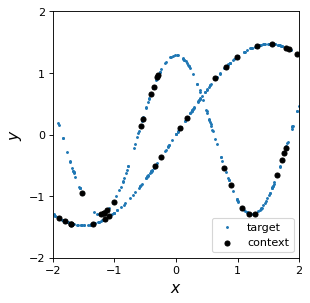

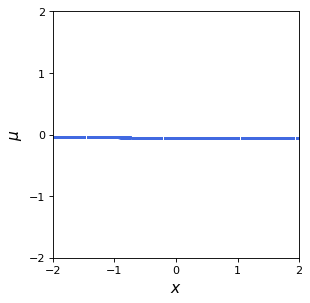

iteration: 0, time: 0.58, train log-likelihood: -2.0419



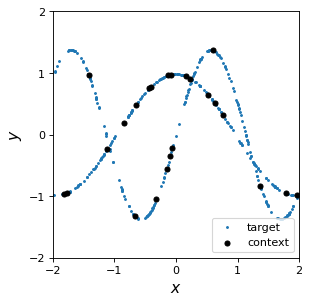

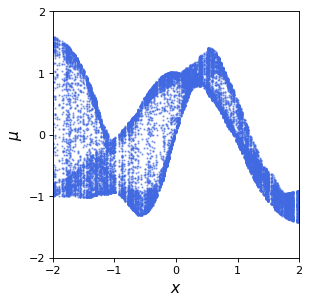

iteration: 5000, time: 0.08, train log-likelihood: 0.0717



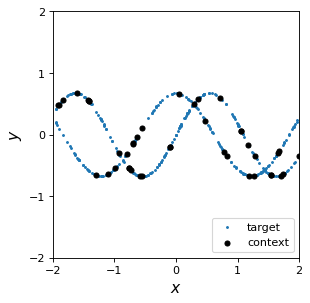

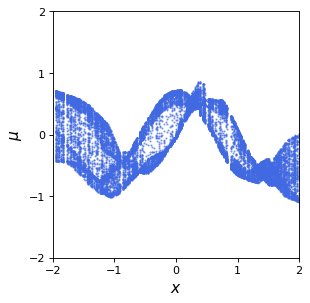

iteration: 10000, time: 0.08, train log-likelihood: 0.4035



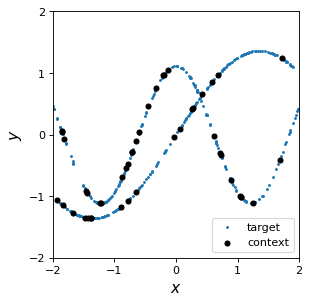

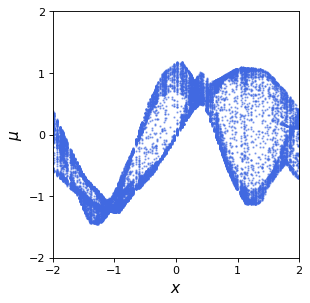

iteration: 15000, time: 0.06, train log-likelihood: 0.0482



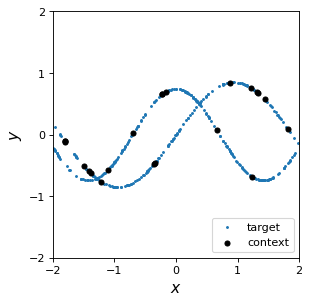

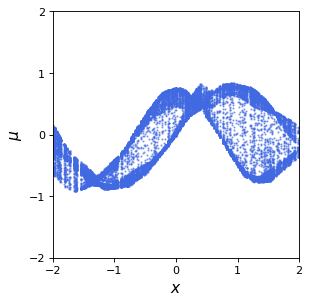

iteration: 20000, time: 0.07, train log-likelihood: 1.2132



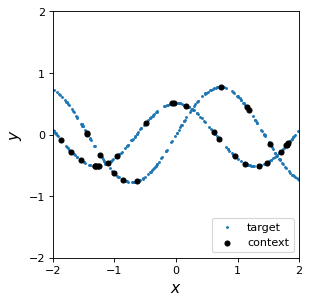

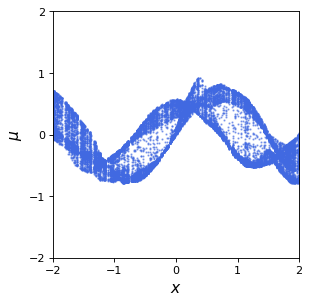

iteration: 25000, time: 0.02, train log-likelihood: 0.6018



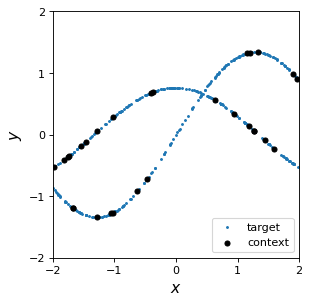

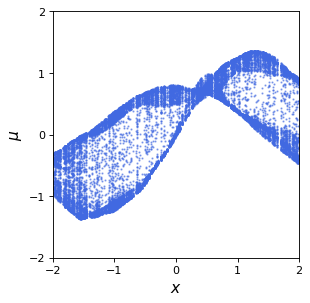

iteration: 30000, time: 0.02, train log-likelihood: 0.4313



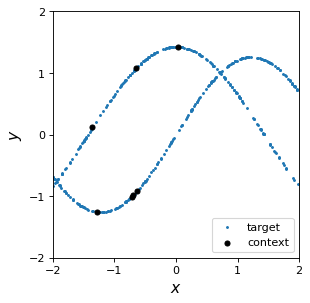

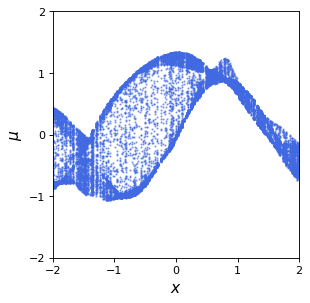

iteration: 35000, time: 0.09, train log-likelihood: -0.2552



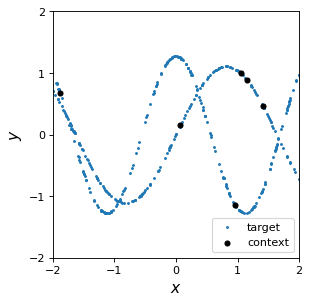

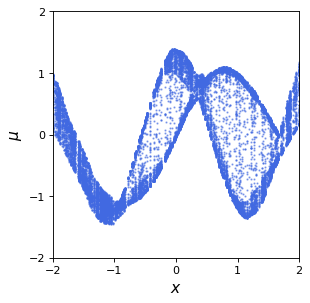

iteration: 40000, time: 0.05, train log-likelihood: 0.3502



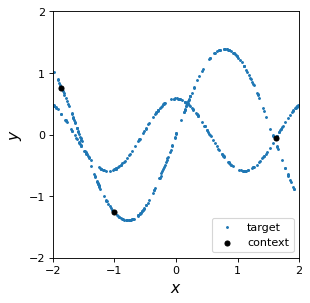

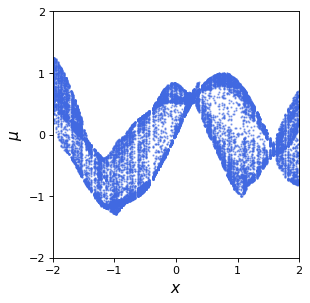

iteration: 45000, time: 0.04, train log-likelihood: -0.7405



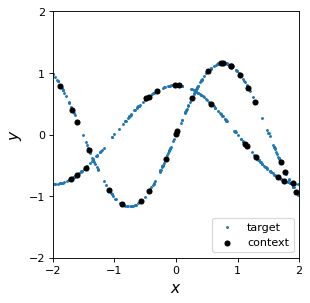

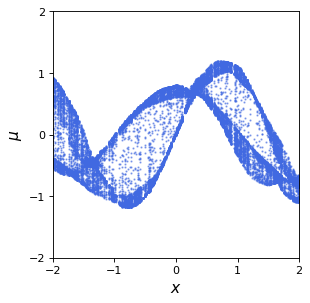

iteration: 50000, time: 0.03, train log-likelihood: 1.0437



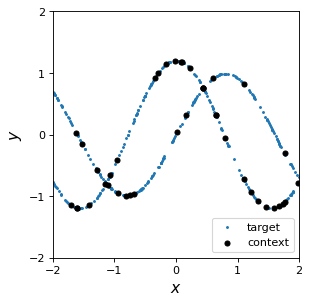

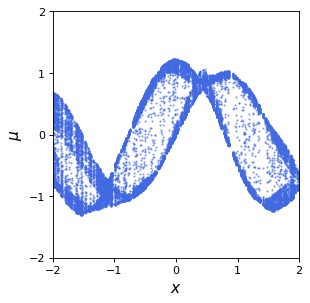

iteration: 55000, time: 0.05, train log-likelihood: 1.1166



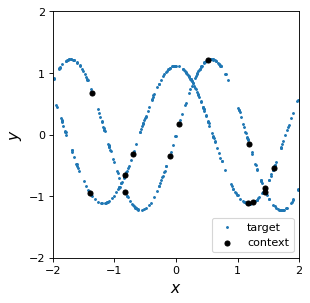

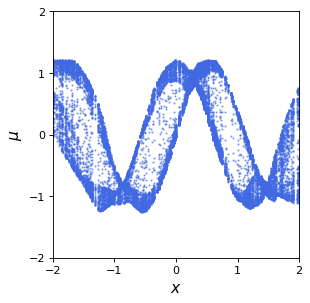

iteration: 60000, time: 0.06, train log-likelihood: 0.5696



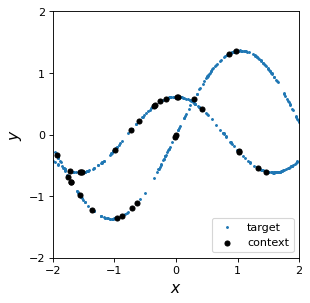

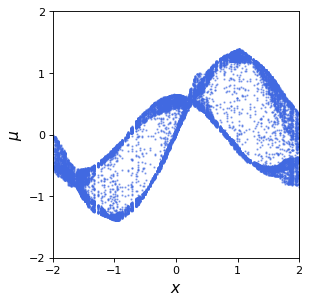

iteration: 65000, time: 0.02, train log-likelihood: 0.8803



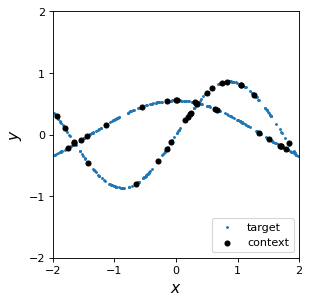

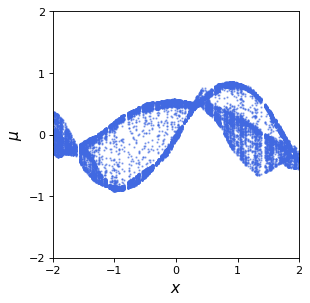

iteration: 70000, time: 0.03, train log-likelihood: 1.2296



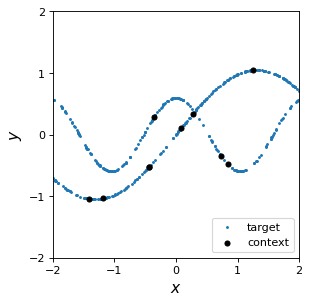

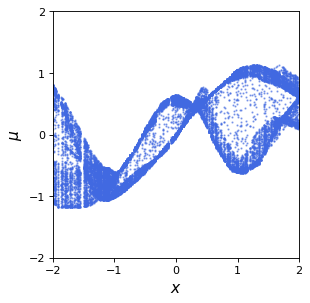

iteration: 75000, time: 0.07, train log-likelihood: 0.6597



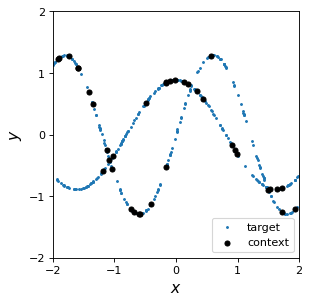

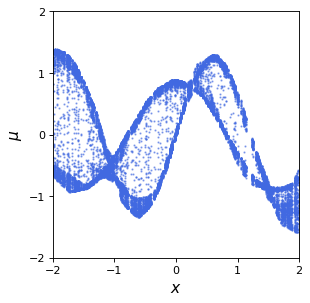

iteration: 80000, time: 0.07, train log-likelihood: 1.4398



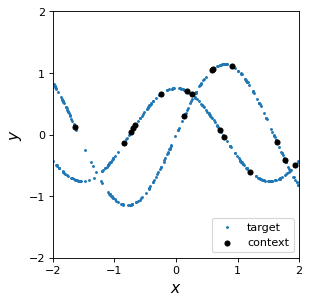

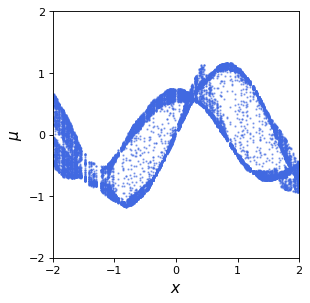

iteration: 85000, time: 0.06, train log-likelihood: 0.9215



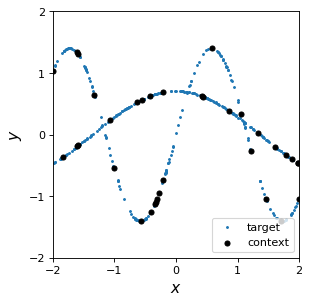

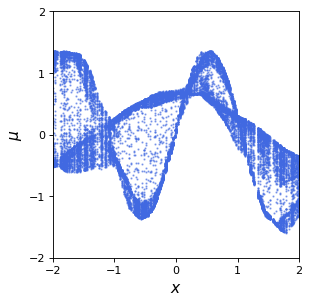

iteration: 90000, time: 0.06, train log-likelihood: 0.6070



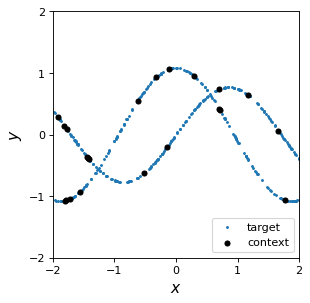

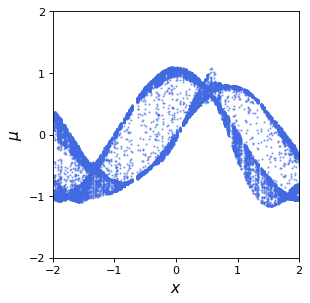

iteration: 95000, time: 0.05, train log-likelihood: 0.7936



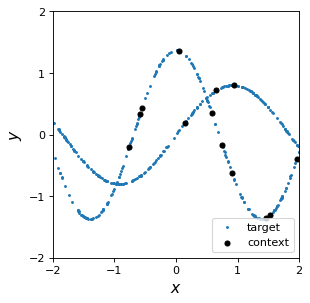

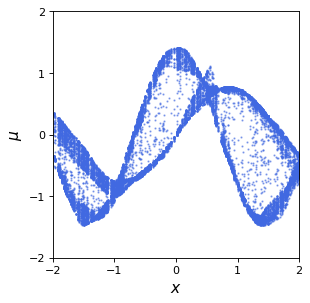

iteration: 99999, time: 0.03, train log-likelihood: 0.4057



In [ ]:
#training
for iteration in range(num_iterations):
    t_start = time.time()
    model.train()
    optimizer.zero_grad()

    if iteration % plot_freq == 0 or iteration == num_iterations-1:
      batch = sampler.sample(
          batch_size=1,
          num_points=400,
          device='cuda')
    else:
      batch = sampler.sample(
          batch_size=train_batch_size,
          max_num_points=max_num_points,
          device='cuda')
      
    outs = model(batch)
    outs['loss'].backward()
    optimizer.step()
    t_end = time.time()

    if iteration % plot_freq == 0 or iteration == num_iterations-1:
        plot(batch.context_x[0], batch.context_y[0],
             batch.target_x[0], batch.target_y[0],
             batch.x_values[0], batch.y_values[0],
             outs['dist']._ALD._loc[0].detach())
        print('iteration: {}, time: {:.2f}, train log-likelihood: {:.4f}\n'.format(
                iteration, t_end - t_start, -outs['loss'].item()))